In [1]:
from pathlib import Path
import sys

repo_root = Path.cwd().parent  # parent of ml_backtest/
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

In [ ]:
from __future__ import annotations
import yaml
import numpy as np
from pathlib import Path
from ml_backtest.a_data_loader import load_data
from ml_backtest.g_walkforward import walkforward_run
from ml_backtest.c_metrics import summarise
from ml_backtest.h_mc_permutation import mc_permutation_pvalue
from ml_backtest.i_runs_test import runs_test
from ml_backtest.j_outputs import show_backtest_report, plot_equity_and_dd, plot_fold_metrics

In [3]:
def load_cfg(config="configs/ml_lg.yaml"):
    if isinstance(config, (str, Path)):
        p = Path(config)
        with p.open("r") as f:
            cfg = yaml.safe_load(f)
        cfg["_config_path"] = str(p.resolve())
        return cfg
    elif isinstance(config, dict):
        return config
    else:
        raise TypeError("config must be a path or dict")

In [4]:

"""
Execute the full walkforward backtest workflow.

- Parses CLI args and config
- Seeds RNG (optional override via `--seed`)
- Loads data and runs walkforward backtest
- Computes metrics and statistical tests
- Writes artifacts under `reports/<tag>_YYYYMMDD_HHMMSS/` - the date of backtest run
- Prints a JSON summary to stdout
"""

cfg = load_cfg("configs/ml_lg.yaml")

seed = cfg.get("seed", 5)
rng = np.random.default_rng(seed)

df = load_data(cfg)

folds_df, oos_ret, oos_pos, oos_eq = walkforward_run(cfg, df, rng)
summary = summarise(oos_ret, oos_pos)

pval = mc_permutation_pvalue(oos_ret, n_iter=1000, block=5, seed=seed)
z_run, p_run = runs_test(oos_ret)

tag = cfg["output"].get("tag","run")

summary_out = {
    "config": cfg,
    "summary": summary,
    "mc_permutation_pvalue": pval,
    "runs_test_z": z_run,
    "runs_test_p": p_run,
}

show_backtest_report(summary_out)

# print(json.dumps(summary_out, indent=2))


# Backtest Summary — ml_lg

## Metrics

Metric,Value,Target
Ann. return (arith),-1.00%,≥ 8%
Sharpe,-0.08,≥ 0.90
Sortino,-0.06,≥ 1.20
Max drawdown,-51.6%,≥ −25%
Calmar,-0.02,≥ 1.00
Profit factor,0.97,≥ 1.30
Hit rate,19.9%,≥ 53%
Exposure,39.5%,20%–60%
Turnover,50.7,≤ 100
VaR 5%,-0.92%,≥ −3%


## Statistical Tests

Test,Value,Target
MC permutation p-value,0.6803,≤ 0.01
Runs test z,-14.32,∣z∣ ≤ 2.0
Runs test p,0.0000,≥ 0.05


## Config

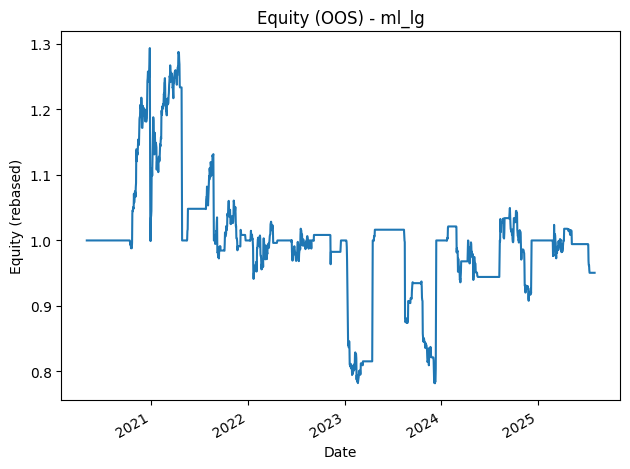

In [5]:
plot_equity_and_dd(oos_eq, f"Equity (OOS) - {tag}")

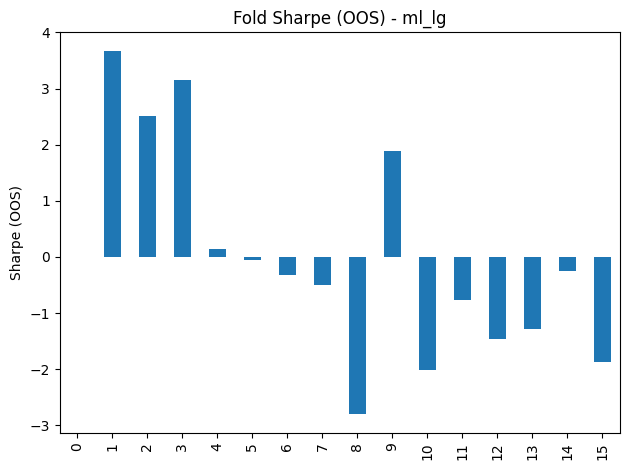

In [6]:
plot_fold_metrics(folds_df, f"Fold Sharpe (OOS) - {tag}")